<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-phoenix-assets/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://docs.arize.com/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://arize-ai.slack.com/join/shared_invite/zt-2w57bhem8-hq24MB6u7yE_ZF_ilOYSBw#/shared-invite/email">Community</a>
    </p>
</center>

# Tracing and Evaluating a Haystack RAG Application with Phoenix

[Phoenix](https://haystack.deepset.ai/integrations/arize-phoenix) is a tool for tracing and evaluating LLM applications. In this tutorial, we will trace and evaluate a Haystack RAG pipeline. We'll evaluate using three different types of evaluations:

1. Relevance: Whether the retrieved documents are relevant to the question.
2. Q&A Correctness: Whether the answer to the question is correct.
3. Hallucination: Whether the answer contains hallucinations.

ℹ️ This notebook requires an OpenAI API key.


In [ ]:
!pip install -q openinference-instrumentation-haystack haystack-ai arize-phoenix

## Set API Keys

In [2]:
from getpass import getpass
import os

if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")

os.environ["OPENAI_API_KEY"] = openai_api_key

🔑 Enter your OpenAI API key: ··········


## Launch Phoenix and Enable Haystack Tracing

If you don't have a Phoenix API key, you can get one for free at [phoenix.arize.com](https://phoenix.arize.com). Arize Phoenix also provides [self-hosting options](https://docs.arize.com/phoenix/self-hosting) if you'd prefer to run the application yourself instead.

In [3]:
if os.getenv("PHOENIX_API_KEY") is None:
    os.environ["PHOENIX_API_KEY"] = getpass("Enter your Phoenix API Key")

os.environ["OTEL_EXPORTER_OTLP_HEADERS"] = f"api_key={os.environ['PHOENIX_API_KEY']}"
os.environ["PHOENIX_CLIENT_HEADERS"] = f"api_key={os.environ['PHOENIX_API_KEY']}"
os.environ["PHOENIX_COLLECTOR_ENDPOINT"] = "https://app.phoenix.arize.com"

Enter your Phoenix API Key··········


The command below connects Phoenix to your Haystack application and instruments the Haystack library. Any calls to Haystack pipelines from this point forward will be traced and logged to the Phoenix UI.

In [ ]:
from phoenix.otel import register

project_name = "Haystack RAG"
tracer_provider = register(project_name=project_name, auto_instrument=True)

## Set up your Haystack app

For a step-by-step guide to create a RAG pipeline with Haystack, follow the [Creating Your First QA Pipeline with Retrieval-Augmentation](https://haystack.deepset.ai/tutorials/27_first_rag_pipeline) tutorial.

In [17]:
from haystack.components.builders import ChatPromptBuilder
from haystack.dataclasses import ChatMessage, Document
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack import Pipeline

# Write documents to InMemoryDocumentStore
document_store = InMemoryDocumentStore()
document_store.write_documents(
    [
        Document(content="My name is Jean and I live in Paris."),
        Document(content="My name is Mark and I live in Berlin."),
        Document(content="My name is Giorgio and I live in Rome."),
    ]
)

# Basic RAG Pipeline
template = [
    ChatMessage.from_system(
"""
Answer the questions based on the given context.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}
Question: {{ question }}
Answer:
"""
    )
]
rag_pipe = Pipeline()
rag_pipe.add_component("retriever", InMemoryBM25Retriever(document_store=document_store))
rag_pipe.add_component("prompt_builder", ChatPromptBuilder(template=template, required_variables="*"))
rag_pipe.add_component("llm", OpenAIChatGenerator(model="gpt-4o-mini"))

rag_pipe.connect("retriever", "prompt_builder.documents")
rag_pipe.connect("prompt_builder.prompt", "llm.messages")

🚅 Components
  - retriever: InMemoryBM25Retriever
  - prompt_builder: ChatPromptBuilder
  - llm: OpenAIChatGenerator
🛤️ Connections
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.messages (List[ChatMessage])

Run the pipeline with a query. It will automatically create a trace on Phoenix.

In [26]:
# Ask a question
question = "Who lives in Paris?"
results = rag_pipe.run(
    {
        "retriever": {"query": question},
        "prompt_builder": {"question": question},
    }
)

print(results["llm"]["replies"][0].text)

Jean lives in Paris.


## Evaluating Retrieved Docs

Now that we've traced our pipeline, let's start by evaluating the retrieved documents.

All evaluations in Phoenix use the same general process:
1. Query and download trace data from Phoenix
2. Add evaluation labels to the trace data. This can be done using the Phoenix library, using Haystack evaluators, or using your own evaluators.
3. Log the evaluation labels to Phoenix
4. View evaluations

We'll use the `get_retrieved_documents` function to get the trace data for the retrieved documents.

In [ ]:
import nest_asyncio
nest_asyncio.apply()

import phoenix as px
client = px.Client()

In [27]:
from phoenix.session.evaluation import get_retrieved_documents

retrieved_documents_df = get_retrieved_documents(px.Client(), project_name=project_name)
retrieved_documents_df.head()

/usr/local/lib/python3.11/dist-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (10.9.1) and client (10.11.0) versions are mismatched and may have compatibility issues.
  warnings.warn(


context.trace_id  \
context.span_id  document_position                                     
40880a3ade3753c3 0                  53d4a3ef151e2dc3009fa6aff152dc86   
                 1                  53d4a3ef151e2dc3009fa6aff152dc86   
                 2                  53d4a3ef151e2dc3009fa6aff152dc86   

                                                                                input  \
context.span_id  document_position                                                      
40880a3ade3753c3 0                  {"query": "Who lives in Paris?", "filters": nu...   
                 1                  {"query": "Who lives in Paris?", "filters": nu...   
                 2                  {"query": "Who lives in Paris?", "filters": nu...   

                                                                 reference  \
context.span_id  document_position                                           
40880a3ade3753c3 0                    My name is Jean and I live in Paris.   
                 1                   My name is Mark and I live in Berlin.   
                 2                  My name is Giorgio and I live in Rome.   

                                    document_score  
context.span_id  document_position                  
40880a3ade3753c3 0                        1.293454  
                 1                        0.768010  
                 2                        0.768010

Next we'll use Phoenix's `RelevanceEvaluator` to evaluate the relevance of the retrieved documents. This evaluator uses a LLM to determine if the retrieved documents contain the answer to the question.

In [28]:
from phoenix.evals import OpenAIModel, RelevanceEvaluator, run_evals

relevance_evaluator = RelevanceEvaluator(OpenAIModel(model="gpt-4o-mini"))

retrieved_documents_relevance_df = run_evals(
    evaluators=[relevance_evaluator],
    dataframe=retrieved_documents_df,
    provide_explanation=True,
    concurrency=20,
)[0]

run_evals |          | 0/3 (0.0%) | ⏳ 00:00<? | ?it/s

In [29]:
retrieved_documents_relevance_df.head()

label  score  \
context.span_id  document_position                     
40880a3ade3753c3 0                   relevant      1   
                 1                  unrelated      0   
                 2                  unrelated      0   

                                                                          explanation  
context.span_id  document_position                                                     
40880a3ade3753c3 0                  The question asks who lives in Paris. The refe...  
                 1                  The question asks about who lives in Paris, wh...  
                 2                  The question asks about who lives in Paris, wh...

Finally, we'll log the evaluation labels to Phoenix.

In [ ]:
from phoenix.trace import DocumentEvaluations, SpanEvaluations

px.Client().log_evaluations(
    DocumentEvaluations(dataframe=retrieved_documents_relevance_df, eval_name="relevance"),
)

If you now click on your document retrieval span in Phoenix, you should see the evaluation labels.



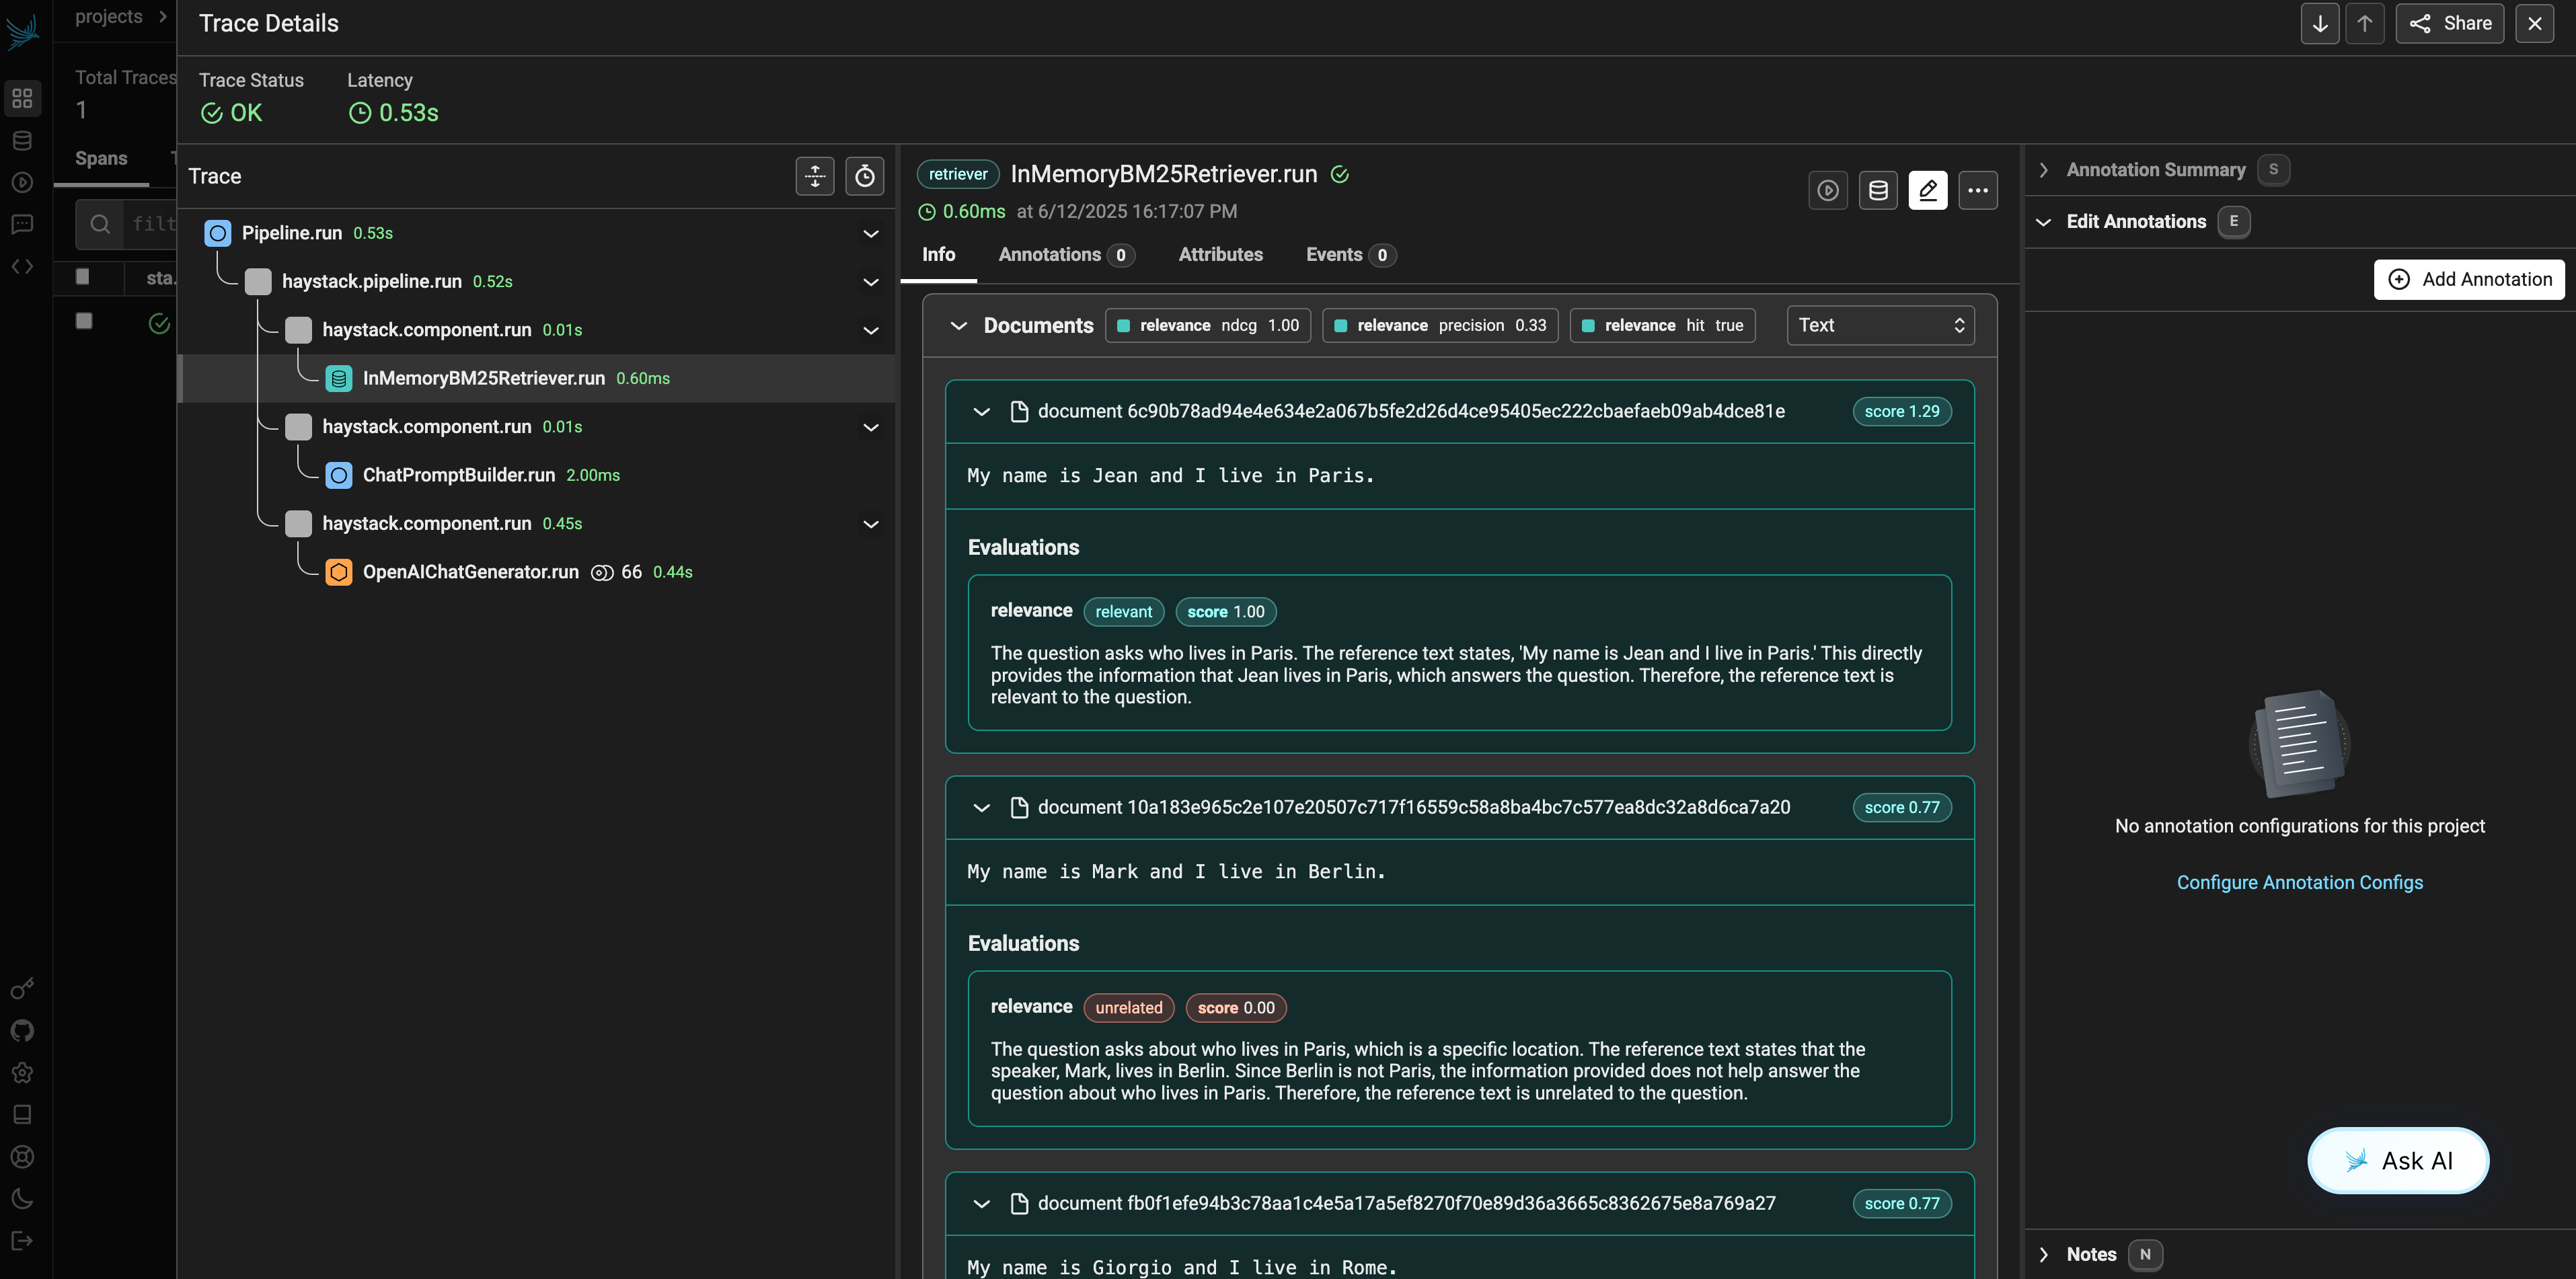

## Evaluate Response

With `HallucinationEvaluator` and `QAEvaluator`, we can detect the correctness and hallucination score of the generated response.

In [32]:
from phoenix.session.evaluation import get_qa_with_reference

qa_with_reference_df = get_qa_with_reference(px.Client(), project_name=project_name)
qa_with_reference_df

/usr/local/lib/python3.11/dist-packages/phoenix/utilities/client.py:60: UserWarning: The Phoenix server (10.9.1) and client (10.11.0) versions are mismatched and may have compatibility issues.
  warnings.warn(


,input,output,reference
context.span_id,,,
a3e33d1e526e97bd,"{""data"": {""retriever"": {""query"": ""Who lives in...","{""llm"": {""replies"": [""ChatMessage(_role=<ChatR...",My name is Jean and I live in Paris.\n\nMy nam...


In [33]:
from phoenix.evals import (
    HallucinationEvaluator,
    OpenAIModel,
    QAEvaluator,
    run_evals,
)

qa_evaluator = QAEvaluator(OpenAIModel(model="gpt-4-turbo-preview"))
hallucination_evaluator = HallucinationEvaluator(OpenAIModel(model="gpt-4-turbo-preview"))

qa_correctness_eval_df, hallucination_eval_df = run_evals(
    evaluators=[qa_evaluator, hallucination_evaluator],
    dataframe=qa_with_reference_df,
    provide_explanation=True,
    concurrency=20,
)

run_evals |          | 0/2 (0.0%) | ⏳ 00:00<? | ?it/s

In [ ]:
px.Client().log_evaluations(
    SpanEvaluations(dataframe=qa_correctness_eval_df, eval_name="Q&A Correctness"),
    SpanEvaluations(dataframe=hallucination_eval_df, eval_name="Hallucination"),
)

You should now see the Q&A correctness and hallucination evaluations in Phoenix.


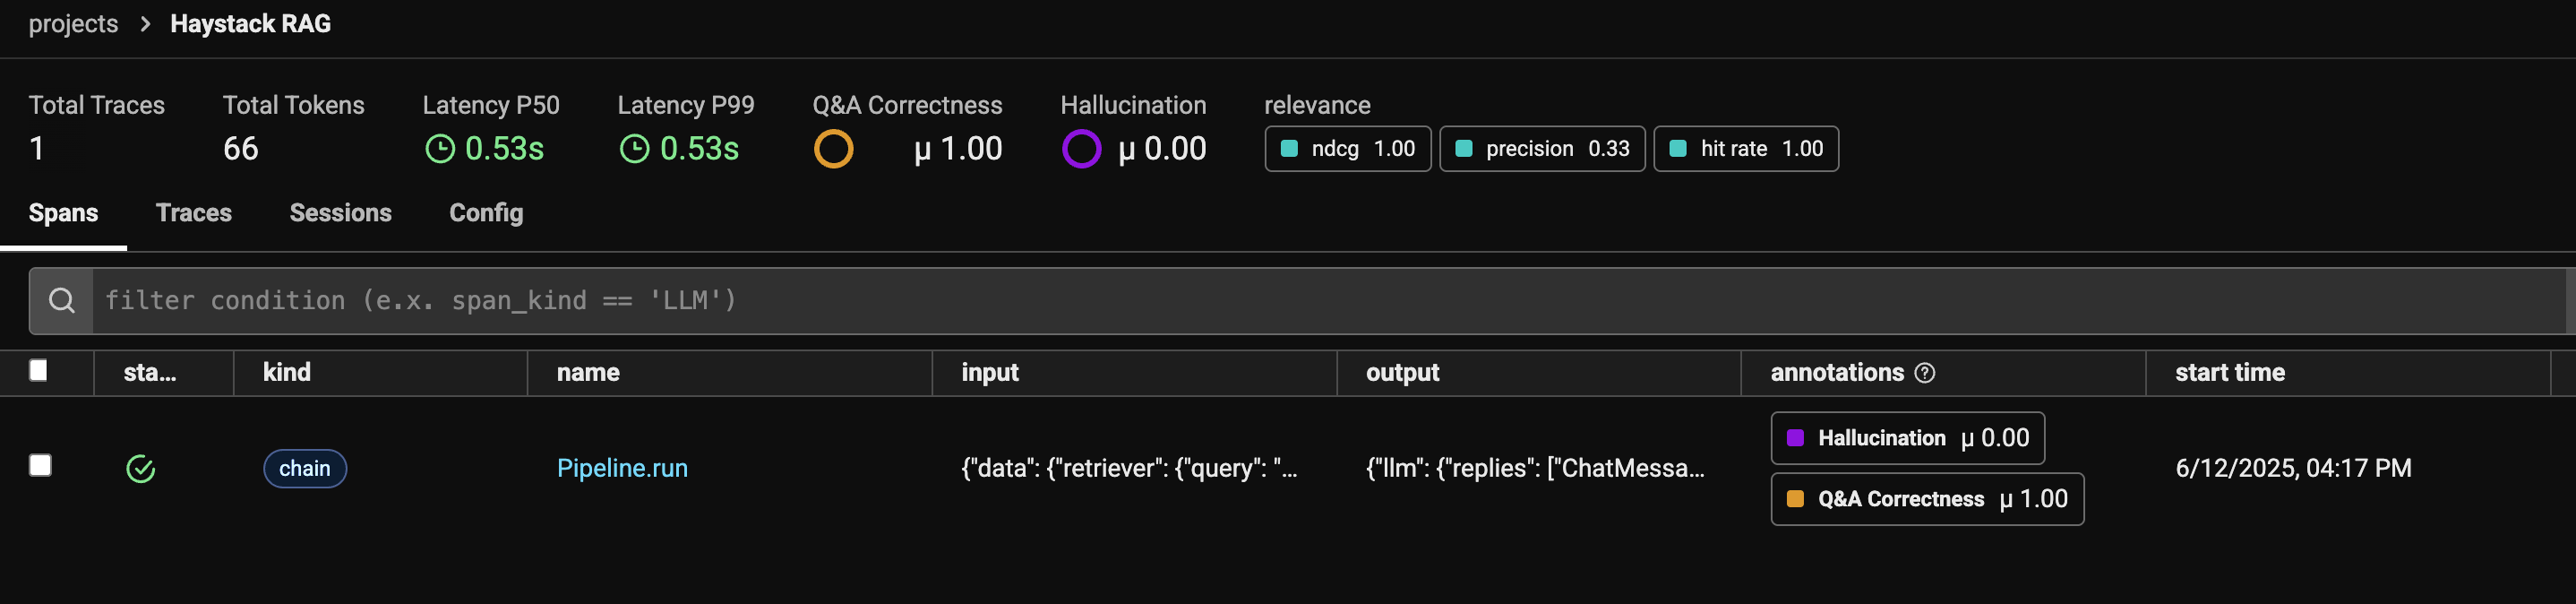